Comparing the DG method with the Trefftz-DG method on the anisotropic mesh in 1+1 dimensions. In this case, both, Trefftz and L2 space are constructed from a space for the second order system. Since the Hessian for the L2 space is needed the following lines have to be added in the constructor for the l2 space in l2hofespace.cpp

    switch (ma->GetDimension())
    {
    case 1:
        additional_evaluators.Set ("hesse", make_shared<T_DifferentialOperator<DiffOpHesse<1>>> ());
        break;
    case 2:
        additional_evaluators.Set ("hesse", make_shared<T_DifferentialOperator<DiffOpHesse<2>>> ());
        break;
    case 3:
        additional_evaluators.Set ("hesse", make_shared<T_DifferentialOperator<DiffOpHesse<3>>> ());
        additional_evaluators.Set ("hesseboundary", make_shared<T_DifferentialOperator<DiffOpHesseBoundary<3>>> ());
        break;
    default:
        ;
    }

## Define Functions

In [1]:
from ngsolve import *
SetHeapSize(100*1000*1000)

from trefftzngs import *
import numpy as np
import scipy.linalg as spla

In [2]:
def MakeMesh():
    import netgen.meshing as ngm
    from netgen.geom2d import unit_square
    
    ngmesh = ngm.Mesh()
    ngmesh.SetGeometry(unit_square)
    ngmesh.dim = 2
    pnums = []
    for i in range(t_steps + 1):
        for j in range(N + 1):
            pnums.append(ngmesh.Add(ngm.MeshPoint(ngm.Pnt(i / t_steps, j / N, 0))))

    foo = ngm.FaceDescriptor(surfnr=1,domin=1,bc=1)
    ngmesh.Add (foo)
    ngmesh.SetMaterial(1, "mat")
    for j in range(t_steps):
        for i in range(N):
            ngmesh.Add(ngm.Element2D(1, [
                                        pnums[i + j * (N + 1)],
                                        pnums[i + 1 + j * (N + 1)],
                                        pnums[i + 1 + (j + 1) * (N + 1)],
                                        pnums[i + (j + 1) * (N + 1)],
                                         ]))
    for i in range(t_steps):
       ngmesh.Add(ngm.Element1D([pnums[N + i * (N + 1)], pnums[N + (i + 1) * (N + 1)]], index=1))
       ngmesh.Add(ngm.Element1D([pnums[0 + i * (N + 1)], pnums[0 + (i + 1) * (N + 1)]], index=1))
    for i in range(N):
       ngmesh.Add(ngm.Element1D([pnums[i], pnums[i + 1]], index=2))
       ngmesh.Add(ngm.Element1D([pnums[i + t_steps * (N + 1)], pnums[i + 1 + t_steps * (N + 1)]], index=2))

    mesh = Mesh(ngmesh)
    return mesh

In [3]:
def MakeSystem(fes,fullsys=False, alpha=0,beta=0,gamma=1):
    U = fes.TrialFunction()
    V = fes.TestFunction()

    v = grad(U)[1]
    sig = -grad(U)[0]
    w = grad(V)[1]
    tau = -grad(V)[0]

    vo = grad(U.Other())[1]
    sigo = -grad(U.Other())[0]
    wo = grad(V.Other())[1]
    tauo = -grad(V.Other())[0]

    h = specialcf.mesh_size
    n = specialcf.normal(2)
    n_t = n[1]/Norm(n)
    n_x = n[0]/Norm(n)

    mean_v = 0.5*(v+vo)
    mean_w = 0.5*(w+wo)
    mean_sig = 0.5*(sig+sigo)
    mean_tau = 0.5*(tau+tauo)

    jump_vx = ( v - vo ) * n_x
    jump_wx = ( w - wo ) * n_x
    jump_sigx = ( sig - sigo ) * n_x
    jump_taux = ( tau - tauo ) * n_x

    jump_vt = ( v - vo ) * n_t
    jump_wt = ( w - wo ) * n_t
    jump_sigt = ( sig - sigo ) * n_t
    jump_taut = ( tau - tauo ) * n_t

    jump_Ut = (U - U.Other()) * n_t

    timelike = n_x**2 #IfPos(n_t,0,IfPos(-n_t,0,1)) # n_t=0
    spacelike = n_t**2 #IfPos(n_x,0,IfPos(-n_x,0,1)) # n_x=0

    a = BilinearForm(fes)
    # a += SymbolicBFI( spacelike * ( IfPos(n_t,v,vo)*(pow(c,-2)*jump_wt+jump_taux) + IfPos(n_t,sig,sigo)*(jump_wx+jump_taut) ) ,VOL,  skeleton=True ) #space like faces
    a += SymbolicBFI( spacelike * ( IfPos(n_t,v,vo)*(pow(c,-2)*jump_wt) + IfPos(n_t,sig,sigo)*(jump_taut) ) ,VOL,  skeleton=True ) #space like faces, no jump in x since horizontal
    a += SymbolicBFI( timelike 	* ( mean_v*jump_taux + mean_sig*jump_wx + alpha*jump_vx*jump_wx + beta*jump_sigx*jump_taux ) ,VOL, skeleton=True ) #time like faces
    a += SymbolicBFI( spacelike * IfPos(n_t,1,0) * ( pow(c,-2)*v*w + sig*tau ), BND, skeleton=True) #t=T (or *x)
    a += SymbolicBFI( timelike 	* ( sig*n_x*w + alpha*v*w ), BND, skeleton=True) #dirichlet boundary 'timelike'
    a += SymbolicBFI( spacelike * ( gamma * (-n_t*jump_Ut)*IfPos(n_t,V.Other(),V) ) ,VOL,  skeleton=True ) #correction term to recover sol of second order system
    a += SymbolicBFI( spacelike * ( gamma * IfPos(-n_t,1,0) * U*V ) ,BND,  skeleton=True ) #BND correction term to recover sol of second order system
    if(fullsys==True):
        HV = V.Operator("hesse")
        a += SymbolicBFI(  -v*(-HV[0]+pow(c,-2)*HV[3]) - sig*(-HV[1]+HV[2])  )
    
    f = LinearForm(fes)
    f += SymbolicLFI( spacelike * IfPos(-n_t,1,0) *  ( pow(c,-2)*v0*w + sig0*tau ), BND, skeleton=True) #t=0 (or *(1-x))
    f += SymbolicLFI( timelike 	* ( v0 * (alpha*w - tau*n_x) ), BND, skeleton=True) #dirichlet boundary 'timelike'
    f += SymbolicLFI( spacelike * gamma * IfPos(-n_t,1,0) *  ( (truesol)*V ) ,BND,  skeleton=True ) #rhs correction term to recover sol of second order system
    
    a.Assemble()
    f.Assemble()
    return [a,f]
    # gfu2= GridFunction(fes, name="uDG")
    # gfu2.vec.data = a.mat.Inverse() * f.vec

In [4]:
def SolveNp(a,f,fes):
    gfu = GridFunction(fes, name="uDG")

    nmat = np.zeros((a.mat.height,a.mat.width))
    nmatcond = np.zeros((a.mat.height,a.mat.width))
    nvec = np.zeros(a.mat.width)

    for i in range(a.mat.width):#gfu.vec.data = a.mat.Inverse() * f.vec
        nvec[i] = f.vec[i]/sqrt(a.mat[i,i])
        if(a.mat[i,i]<0):
            print(a.mat[i,i])
        for j in range(a.mat.height):
            nmat[j,i] = a.mat[j,i]/sqrt(a.mat[i,i]*a.mat[j,j])
    
    sol = spla.solve(nmat,nvec)
    
    for i in range(a.mat.height):
        gfu.vec[i] = sol[i]/sqrt(a.mat[i,i])
        
    #print(min(np.linalg.eigvalsh(0.5*(nmat + nmat.transpose()))))
    #nmatinv = np.linalg.inv(nmat)
    #print(min(np.linalg.eigvalsh(0.5*(nmatinv + nmatinv.transpose()))))
    #nvec = f.vec.FV().NumPy() #nvec
    # print("cond nmat: ", np.linalg.cond(nmat))
    return [gfu,np.linalg.cond(nmat)]

In [5]:
def SolveWaveeq(fes,fullsys):
    alpha = 0.5
    beta = 0.5

    [a,f] = MakeSystem(fes,fullsys,alpha,beta)
    [gfu,cond] = SolveNp(a,f,fes)
    
    L2error = sqrt(Integrate((truesol - gfu)*(truesol - gfu), mesh))
    
    U0 = GridFunction(fes)
    U0.Set(truesol)
    sH1error = sqrt(Integrate((grad(U0) - grad(gfu))*(grad(U0) - grad(gfu)), mesh))
    
    dof=fes.ndof/(N*t_steps)
    
    return [dof,cond,L2error,sH1error]

## Run comparison

In [6]:
N = 2
c = 2
t_steps = c*N
order = 12
k = 1
D = 2

truesol =  sin( k*(c*y + x) )#exp(-pow(c*x+y,2)))#
v0 = c*k*cos(k*(c*y+x))#grad(U0)[0]
sig0 = -k*cos(k*(c*y+x))#-grad(U0)[1]

mesh = MakeMesh()

solution = []

for ordr in range(2,order):
    print("run order: " + str(ordr))

    btype = 0
    fes = L2(mesh, order=ordr, dgjumps=True)
    [dof,cond,L2error,sH1error] = SolveWaveeq(fes, True)
    solution.append([btype, ordr, dof,cond,L2error,sH1error])
    print("btype: " + 'L2' + " dof: " + str(dof) + " cond: " + str(cond) + " L2error: " + str(L2error) + " H1error: "+ str(sH1error))

    btype = 1
    fes = FESpace("trefftzfespace", mesh, order = ordr, wavespeed = c, dgjumps=True, basistype = 0)
    [dof,cond,L2error,sH1error] = SolveWaveeq(fes, False)
    solution.append([btype,ordr,dof,cond,L2error,sH1error])
    print("btype: " + 'Trefftz' + " dof: " + str(dof) + " cond: " + str(cond) + " L2error: " + str(L2error) + " H1error: "+ str(sH1error))

run order: 2
btype: L2 dof: 9.0 cond: 24.9756308814 L2error: 0.006755610526802402 H1error: 0.0542735140762072
btype: Trefftz dof: 5.0 cond: 8.65559648566 L2error: 0.010136977478429727 H1error: 0.06465871179347105
run order: 3
btype: L2 dof: 16.0 cond: 58.3154452536 L2error: 0.0006364280284609354 H1error: 0.00819231070137468
btype: Trefftz dof: 7.0 cond: 47.3131891014 L2error: 0.0013537323560042426 H1error: 0.010630769439527794
run order: 4
btype: L2 dof: 25.0 cond: 125.679725559 L2error: 1.772905069965455e-05 H1error: 0.0002896537582663558
btype: Trefftz dof: 9.0 cond: 96.178927935 L2error: 3.5064984933015635e-05 H1error: 0.0005452395034070366
run order: 5
btype: L2 dof: 36.0 cond: 241.61375792 L2error: 8.303486171599296e-07 H1error: 2.2565867304762258e-05
btype: Trefftz dof: 11.0 cond: 526.428337906 L2error: 2.683383727273687e-06 H1error: 4.249099357911255e-05
run order: 6
btype: L2 dof: 49.0 cond: 496.047167082 L2error: 2.0363148485927197e-08 H1error: 6.308556887612309e-07
btype: Tre

## Draw Comparison

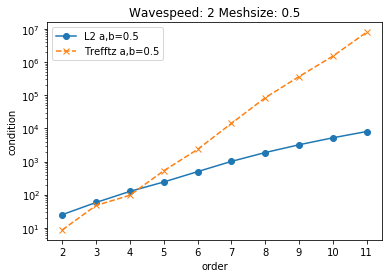

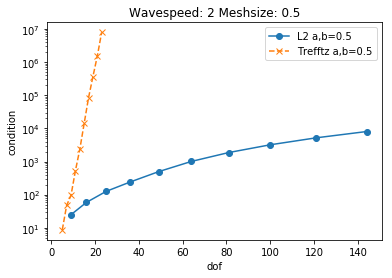

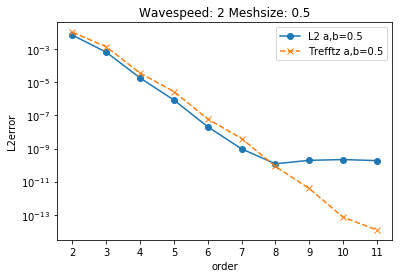

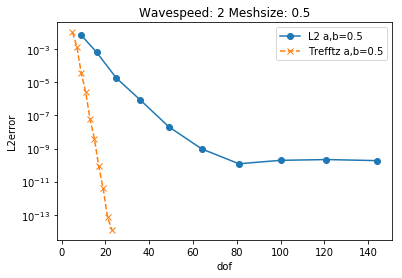

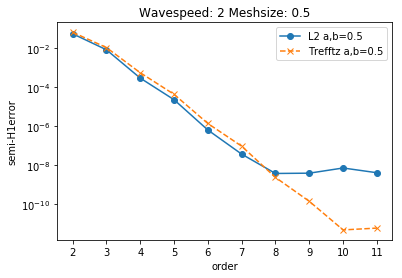

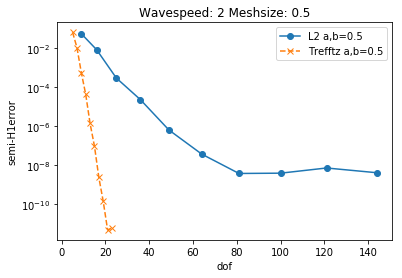

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

label = ['','order','dof','condition', 'L2error', 'semi-H1error']
sol = np.array(solution)

for yaxis in [3,4,5]:
    for xaxis in [1,2]:
        fig = plt.figure()
        ax = fig.gca()
        plt.semilogy(sol[sol[:,0]==0,xaxis], sol[sol[:,0]==0,yaxis], '-o', label="L2 a,b=0.5")
        plt.semilogy(sol[sol[:,0]==1,xaxis], sol[sol[:,0]==1,yaxis], '--x', label="Trefftz a,b=0.5")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title('Wavespeed: ' + str(c) + " Meshsize: " + str(1/N))
        plt.legend()
        plt.ylabel(label[yaxis])
        plt.xlabel(label[xaxis])
        #plt.savefig("results/pvtnew_"+label[yaxis]+label[xaxis]+".png")
        plt.show()